# **第8章: ニューラルネット**

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

### **70. 単語ベクトルの和による特徴量**

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-01-20 06:53:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  7.31MB/s    in 4.0s    

2023-01-20 06:53:18 (7.00 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [4]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [6]:
import gdown

url = 'https://drive.google.com/uc?export=download&confirm=pbef&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)

from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:20<00:00, 79.3MB/s]


In [7]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [8]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [9]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [10]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

### **71. 単層ニューラルネットワークによる予測**

In [11]:
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [12]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.7064, 0.0551, 0.1618, 0.0767]], grad_fn=<SoftmaxBackward0>)


In [13]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.7064, 0.0551, 0.1618, 0.0767],
        [0.1968, 0.4333, 0.2015, 0.1684],
        [0.3047, 0.3078, 0.1483, 0.2392],
        [0.1086, 0.4489, 0.0225, 0.4200]], grad_fn=<SoftmaxBackward0>)


### **72. 損失と勾配の計算**

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.3476
勾配:
tensor([[-0.0246, -0.0017, -0.0020,  ..., -0.0221, -0.0127,  0.0255],
        [ 0.0046,  0.0003,  0.0004,  ...,  0.0041,  0.0024, -0.0048],
        [ 0.0135,  0.0009,  0.0011,  ...,  0.0122,  0.0070, -0.0140],
        [ 0.0064,  0.0004,  0.0005,  ...,  0.0058,  0.0033, -0.0067]])


In [16]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.6022
勾配:
tensor([[-0.0019,  0.0010, -0.0094,  ..., -0.0142,  0.0048,  0.0120],
        [-0.0045,  0.0007,  0.0145,  ...,  0.0111,  0.0214,  0.0045],
        [ 0.0205, -0.0111, -0.0225,  ..., -0.0005, -0.0057,  0.0043],
        [-0.0141,  0.0095,  0.0175,  ...,  0.0036, -0.0205, -0.0209]])


### **73. 確率的勾配降下法による学習**

In [17]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [18]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [19]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()
 
  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.4693, loss_valid: 0.3669
epoch: 2, loss_train: 0.3111, loss_valid: 0.3367
epoch: 3, loss_train: 0.2822, loss_valid: 0.3288
epoch: 4, loss_train: 0.2666, loss_valid: 0.3147
epoch: 5, loss_train: 0.2562, loss_valid: 0.3106
epoch: 6, loss_train: 0.2488, loss_valid: 0.3076
epoch: 7, loss_train: 0.2433, loss_valid: 0.3091
epoch: 8, loss_train: 0.2395, loss_valid: 0.3112
epoch: 9, loss_train: 0.2361, loss_valid: 0.3098
epoch: 10, loss_train: 0.2330, loss_valid: 0.3084


### **74. 正解率の計測**

In [20]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [21]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.925
正解率（評価データ）：0.899


### **75. 損失と正解率のプロット**

In [22]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

In [23]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3415, accuracy_train: 0.8816, loss_valid: 0.3660, accuracy_valid: 0.8720
epoch: 2, loss_train: 0.2889, accuracy_train: 0.9016, loss_valid: 0.3203, accuracy_valid: 0.8975
epoch: 3, loss_train: 0.2698, accuracy_train: 0.9083, loss_valid: 0.3115, accuracy_valid: 0.9004
epoch: 4, loss_train: 0.2571, accuracy_train: 0.9124, loss_valid: 0.3078, accuracy_valid: 0.8982
epoch: 5, loss_train: 0.2463, accuracy_train: 0.9164, loss_valid: 0.3024, accuracy_valid: 0.9034
epoch: 6, loss_train: 0.2387, accuracy_train: 0.9202, loss_valid: 0.3019, accuracy_valid: 0.8990
epoch: 7, loss_train: 0.2379, accuracy_train: 0.9213, loss_valid: 0.3048, accuracy_valid: 0.8982
epoch: 8, loss_train: 0.2324, accuracy_train: 0.9212, loss_valid: 0.3049, accuracy_valid: 0.8945
epoch: 9, loss_train: 0.2282, accuracy_train: 0.9236, loss_valid: 0.3030, accuracy_valid: 0.8975
epoch: 10, loss_train: 0.2259, accuracy_train: 0.9243, loss_valid: 0.3029, accuracy_valid: 0.8967
epoch: 11, loss_train: 0.2231

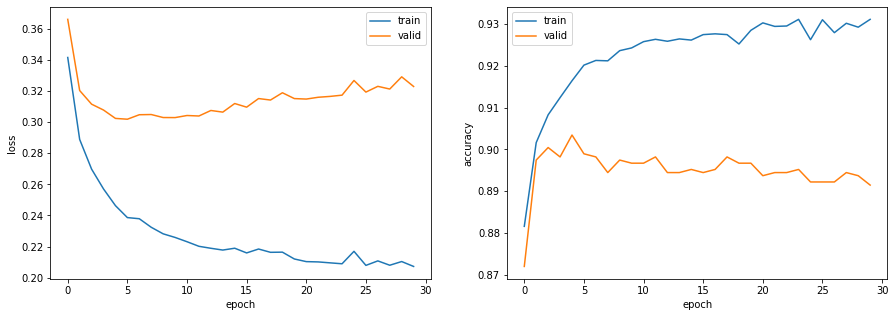

In [24]:
from matplotlib import pyplot as plt
import numpy as np


# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

### **76. チェックポイント**

In [25]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3307, accuracy_train: 0.8873, loss_valid: 0.3626, accuracy_valid: 0.8728
epoch: 2, loss_train: 0.2853, accuracy_train: 0.9046, loss_valid: 0.3297, accuracy_valid: 0.8907
epoch: 3, loss_train: 0.2771, accuracy_train: 0.9073, loss_valid: 0.3300, accuracy_valid: 0.8937
epoch: 4, loss_train: 0.2534, accuracy_train: 0.9155, loss_valid: 0.3106, accuracy_valid: 0.8997
epoch: 5, loss_train: 0.2470, accuracy_train: 0.9192, loss_valid: 0.3092, accuracy_valid: 0.8982
epoch: 6, loss_train: 0.2415, accuracy_train: 0.9174, loss_valid: 0.3081, accuracy_valid: 0.8952
epoch: 7, loss_train: 0.2339, accuracy_train: 0.9218, loss_valid: 0.3053, accuracy_valid: 0.9004
epoch: 8, loss_train: 0.2312, accuracy_train: 0.9221, loss_valid: 0.3092, accuracy_valid: 0.8937
epoch: 9, loss_train: 0.2274, accuracy_train: 0.9246, loss_valid: 0.3047, accuracy_valid: 0.8960
epoch: 10, loss_train: 0.2249, accuracy_train: 0.9257, loss_valid: 0.3065, accuracy_valid: 0.8967


### **77. ミニバッチ化**

In [26]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [27]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3308, accuracy_train: 0.8848, loss_valid: 0.3571, accuracy_valid: 0.8743, 4.2507sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3028, accuracy_train: 0.8949, loss_valid: 0.3349, accuracy_valid: 0.8892, 2.3061sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2944, accuracy_train: 0.8987, loss_valid: 0.3281, accuracy_valid: 0.8960, 1.2378sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2900, accuracy_train: 0.9018, loss_valid: 0.3257, accuracy_valid: 0.8930, 0.7113sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2877, accuracy_train: 0.9019, loss_valid: 0.3244, accuracy_valid: 0.8982, 0.4220sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2868, accuracy_train: 0.9021, loss_valid: 0.3238, accuracy_valid: 0.8967, 0.2681sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2864, accuracy_train: 0.9024, loss_valid: 0.3236, accuracy_valid: 0.8960, 0.1935sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2853, accuracy_train: 0.9028, loss_valid: 0.3235, accuracy_valid: 0.8952, 0.1648sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2857, accuracy_

### **78. GPU上での学習**

In [28]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [29]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3280, accuracy_train: 0.8879, loss_valid: 0.3493, accuracy_valid: 0.8802, 12.4485sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2998, accuracy_train: 0.8972, loss_valid: 0.3292, accuracy_valid: 0.8877, 4.8436sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2910, accuracy_train: 0.9002, loss_valid: 0.3246, accuracy_valid: 0.8870, 2.4840sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2872, accuracy_train: 0.9006, loss_valid: 0.3222, accuracy_valid: 0.8892, 1.3395sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2852, accuracy_train: 0.9010, loss_valid: 0.3204, accuracy_valid: 0.8885, 0.7063sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2843, accuracy_train: 0.9013, loss_valid: 0.3198, accuracy_valid: 0.8892, 0.4202sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2840, accuracy_train: 0.9018, loss_valid: 0.3196, accuracy_valid: 0.8892, 0.2545sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2839, accuracy_train: 0.9019, loss_valid: 0.3195, accuracy_valid: 0.8892, 0.1789sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2831, accuracy

### **79. 多層ニューラルネットワーク**

In [30]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))
 
    return x

In [31]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [32]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 1.3083, accuracy_train: 0.5401, loss_valid: 1.3039, accuracy_valid: 0.5359, 0.4927sec
epoch: 2, loss_train: 1.0685, accuracy_train: 0.6615, loss_valid: 1.0651, accuracy_valid: 0.6594, 0.4761sec
epoch: 3, loss_train: 0.8065, accuracy_train: 0.7480, loss_valid: 0.8064, accuracy_valid: 0.7418, 0.4646sec
epoch: 4, loss_train: 0.6733, accuracy_train: 0.7798, loss_valid: 0.6775, accuracy_valid: 0.7814, 0.4825sec
epoch: 5, loss_train: 0.6168, accuracy_train: 0.7854, loss_valid: 0.6242, accuracy_valid: 0.7919, 0.4660sec
epoch: 6, loss_train: 0.5771, accuracy_train: 0.7997, loss_valid: 0.5886, accuracy_valid: 0.8001, 0.4821sec
epoch: 7, loss_train: 0.5412, accuracy_train: 0.8123, loss_valid: 0.5569, accuracy_valid: 0.8099, 0.4588sec
epoch: 8, loss_train: 0.5091, accuracy_train: 0.8249, loss_valid: 0.5277, accuracy_valid: 0.8204, 0.4679sec
epoch: 9, loss_train: 0.4815, accuracy_train: 0.8374, loss_valid: 0.5024, accuracy_valid: 0.8331, 0.4837sec
epoch: 10, loss_train: 0.457

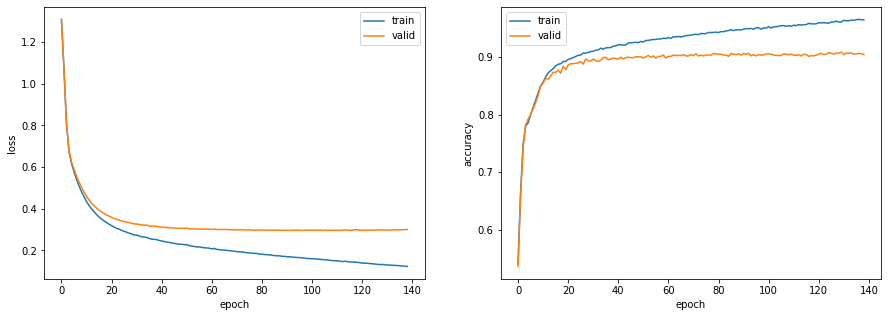

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [34]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [35]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.965
正解率（評価データ）：0.912
